In [20]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.datasets as Dataset
import torch.optim as optim
import torchvision.transforms as Transforms
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import pandas as pd
import os

import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Hyperparameters

INPUT_SIZE = 27000
NUM_CLASSES = 10
BATCH_SIZE = 128
NUM_EPOCHS = 5
LEARNING_RATE = 0.01

In [6]:
seed = 34265
generator = torch.Generator()
generator.manual_seed(seed)

In [7]:
# Load Data
'''
Transform the data from numpy arrays to tensor and save it in data folder
'''
eurosat_dataset = Dataset.EuroSAT(root="data/",download=True, transform=Transforms.ToTensor()) 
dataset_loader = DataLoader(dataset=eurosat_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=generator)

# test set
# test_dataset = Dataset.EuroSAT(root="data/", download=True, transform=Transforms.ToTensor()) 
# testloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [8]:
class EuroSAT_Dataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image']
        img = Image.open(img_path)

        if self.transform:
            img = self.transform(img)
        label = self.df.iloc[idx]['label']
        
        return img, label

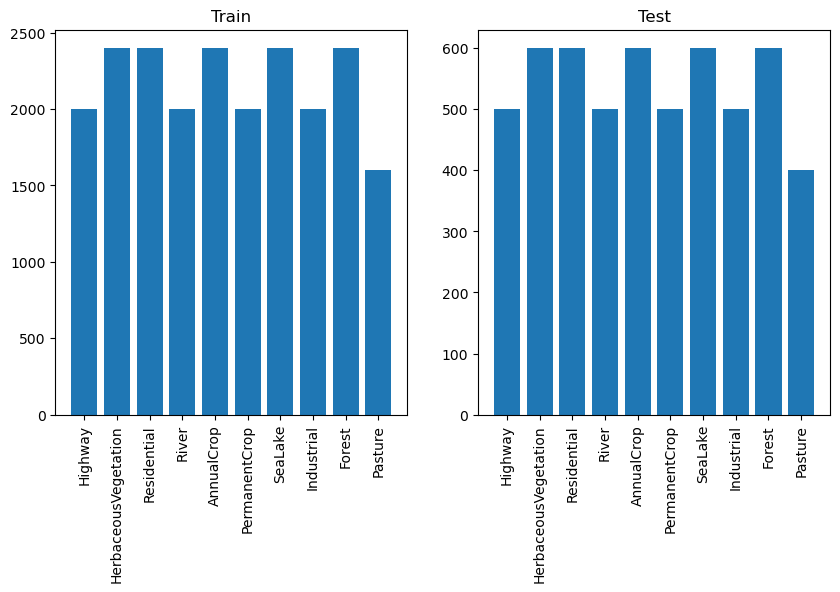

In [12]:
data_dir = "./data/eurosat/2750/"

train_df = pd.DataFrame(columns=["image", "label"])
test_df = pd.DataFrame(columns=["image", "label"])
classes = os.listdir(data_dir)
class_to_idx = {classes[i]: i for i in range(len(classes))}
# idx_to_class = {i: classes[i] for i in range(len(classes))}
idx_to_class = {class_to_idx[i]: i for i in class_to_idx.keys()}

for cls in classes:
    images = [
        os.path.join(data_dir, cls, i) for i in os.listdir(os.path.join(data_dir, cls))
    ]
    labels = [class_to_idx[cls]] * len(images)
    df = pd.DataFrame({"image": images, "label": labels})
    df = df.sample(frac=1).reset_index(drop=True)
    train_df = pd.concat([train_df, df.iloc[: int(0.8 * len(df))]], ignore_index=True)
    test_df = pd.concat([test_df, df.iloc[int(0.8 * len(df)) :]], ignore_index=True)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Train")
plt.bar(classes, [len(train_df[train_df["label"] == class_to_idx[i]]) for i in classes])
plt.xticks(rotation=90)
plt.subplot(1, 2, 2)
plt.title("Test")
plt.bar(classes, [len(test_df[test_df["label"] == class_to_idx[i]]) for i in classes])
plt.xticks(rotation=90)
plt.show()

In [13]:
normalise_means = [0.4914, 0.4822, 0.4465]
normalise_stds = [0.2023, 0.1994, 0.2010]

train_transform = Transforms.Compose([Transforms.RandomHorizontalFlip(),
    Transforms.ToTensor(),
    Transforms.Normalize(normalise_means, normalise_stds),])

test_transforms = Transforms.Compose([Transforms.ToTensor(), Transforms.Normalize(normalise_means, normalise_stds)])

train_dataset = EuroSAT_Dataset(train_df, train_transform)
test_dataset = EuroSAT_Dataset(test_df, test_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)

In [14]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(Block, self).__init__()
        self.expantion = 4
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expantion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expantion)

        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x+= identity
        x = self.relu(x)
        return x
    
class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        #layers
        self.layer1 = self._make_layer(block, layers[0], out_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], out_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], out_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], out_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        print(x.shape)
        x = self.maxpool(x)
        print(x.shape)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x


    def _make_layer(self,block, num_residual_blocks, out_channels, stride):
        identity_downsample = None
        layers = []

        if stride!= 1 or self.in_channels!= out_channels*4:
            identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels*4, kernel_size=1, stride=stride),
                                                 nn.BatchNorm2d(out_channels*4))
        
        layers.append(block(self.in_channels, out_channels, identity_downsample, stride))
        self.in_channels = out_channels * 4

        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, out_channels) )
        return nn.Sequential(*layers)
    

In [15]:
def ResNet50(img_channels=3, num_classes=1000):
    return ResNet(Block, [3, 4, 6, 3], img_channels, num_classes)

def ResNet101(img_channels=3, num_classes=1000):
    return ResNet(Block, [3, 4, 23, 3], img_channels, num_classes)

def ResNet152(img_channels=3, num_classes=1000):
    return ResNet(Block, [3, 4, 36, 3], img_channels, num_classes)

In [16]:
model = ResNet50(num_classes=NUM_CLASSES)

In [21]:
def train(model, epochs, optimizer, criterion, scheduler, device, trainloader, testloader):

    train_losses = []
    train_acc = []
    test_losses = []
    test_acc = []
        
    for i in range(epochs):
        running_loss = 0.0
        running_correct = 0
        total = 0
        best_acc = 0.0
        
        print(f"Epoch: {i + 1}")
        
        for images, targets in tqdm(trainloader, desc= "Train\t"):
            
            images, targets = images.to(device), targets.to(device)
            optimizer.zero_grad()
            
            output = model(images)
            loss = criterion(output, targets)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pred = torch.argmax(output, dim=1)
        
            running_correct += (pred == targets).sum().item()
            total += targets.size(0)

        scheduler.step()
        
        train_losses.append(running_loss / len(trainloader))
        train_acc.append(running_correct / total)

        running_test_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():

            for images, targets in tqdm(testloader, desc= "Test\t"):
                images, targets = images.to(device), targets.to(device)

                output = model(images)
                preds = torch.argmax(output, dim=1)

                correct += (preds == targets).sum().item()
                running_test_loss += criterion(output, targets).item()
                total += targets.size(0)

            acc = correct / total
            test_acc.append(acc)
            test_losses.append(running_test_loss / len(testloader))

        if test_acc[-1] > best_acc:
            best_acc = test_acc[-1]
            torch.save(model.state_dict(), '../models/model.pth') 

        print(f"Train Loss: {train_losses[-1]:.3f}, Train Acc: {train_acc[-1]:.3f}, Test Loss: {test_losses[-1]:.3f}, Test Acc: {test_acc[-1]:.3f}\n")

    return train_losses, train_acc, test_losses, test_acc

In [22]:
# optimizer and loss and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=0.001)

In [23]:
train_losses, train_acc, test_losses, test_acc = train(model, NUM_EPOCHS, optimizer, criterion, scheduler, device, train_loader, test_loader)
print("  Finished Training  ")

Epoch: 1


Train	:   0%|          | 0/675 [00:00<?, ?it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   0%|          | 1/675 [00:01<17:20,  1.54s/it]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   0%|          | 2/675 [00:02<13:24,  1.20s/it]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   0%|          | 3/675 [00:03<11:35,  1.04s/it]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   1%|          | 4/675 [00:04<10:23,  1.08it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   1%|          | 5/675 [00:05<10:25,  1.07it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   1%|          | 6/675 [00:05<10:08,  1.10it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   1%|          | 7/675 [00:06<09:31,  1.17it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   1%|          | 8/675 [00:07<10:01,  1.11it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   1%|▏         | 9/675 [00:08<10:51,  1.02it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   1%|▏         | 10/675 [00:09<10:33,  1.05it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   2%|▏         | 11/675 [00:10<09:54,  1.12it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   2%|▏         | 12/675 [00:11<09:24,  1.18it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   2%|▏         | 13/675 [00:12<09:13,  1.20it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   2%|▏         | 14/675 [00:12<09:18,  1.18it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   2%|▏         | 15/675 [00:13<09:32,  1.15it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   2%|▏         | 16/675 [00:14<09:42,  1.13it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   3%|▎         | 17/675 [00:15<09:14,  1.19it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   3%|▎         | 18/675 [00:16<08:50,  1.24it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   3%|▎         | 19/675 [00:16<08:36,  1.27it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   3%|▎         | 20/675 [00:17<08:26,  1.29it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   3%|▎         | 21/675 [00:18<08:37,  1.26it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   3%|▎         | 22/675 [00:19<09:03,  1.20it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   3%|▎         | 23/675 [00:20<09:00,  1.21it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   4%|▎         | 24/675 [00:21<09:57,  1.09it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   4%|▎         | 25/675 [00:22<09:26,  1.15it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   4%|▍         | 26/675 [00:22<08:59,  1.20it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   4%|▍         | 27/675 [00:23<08:54,  1.21it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   4%|▍         | 28/675 [00:24<09:01,  1.19it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   4%|▍         | 29/675 [00:25<08:40,  1.24it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   4%|▍         | 30/675 [00:26<08:37,  1.25it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   5%|▍         | 31/675 [00:26<08:24,  1.28it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   5%|▍         | 32/675 [00:27<08:17,  1.29it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   5%|▍         | 33/675 [00:28<08:06,  1.32it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   5%|▌         | 34/675 [00:29<08:23,  1.27it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   5%|▌         | 35/675 [00:30<08:46,  1.21it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   5%|▌         | 36/675 [00:30<08:42,  1.22it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   5%|▌         | 37/675 [00:31<08:32,  1.24it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   6%|▌         | 38/675 [00:32<08:31,  1.25it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   6%|▌         | 39/675 [00:33<09:08,  1.16it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   6%|▌         | 40/675 [00:34<09:24,  1.12it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   6%|▌         | 41/675 [00:35<08:59,  1.17it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   6%|▌         | 42/675 [00:36<09:13,  1.14it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   6%|▋         | 43/675 [00:36<09:08,  1.15it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   7%|▋         | 44/675 [00:37<08:55,  1.18it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   7%|▋         | 45/675 [00:38<09:26,  1.11it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   7%|▋         | 46/675 [00:39<10:15,  1.02it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   7%|▋         | 47/675 [00:40<09:42,  1.08it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   7%|▋         | 48/675 [00:41<09:40,  1.08it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   7%|▋         | 49/675 [00:42<10:02,  1.04it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   7%|▋         | 50/675 [00:43<09:38,  1.08it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   8%|▊         | 51/675 [00:44<09:52,  1.05it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   8%|▊         | 52/675 [00:45<09:22,  1.11it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   8%|▊         | 53/675 [00:46<09:02,  1.15it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   8%|▊         | 54/675 [00:47<09:01,  1.15it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   8%|▊         | 55/675 [00:47<09:12,  1.12it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   8%|▊         | 56/675 [00:48<09:34,  1.08it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   8%|▊         | 57/675 [00:49<09:51,  1.04it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   9%|▊         | 58/675 [00:51<10:03,  1.02it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   9%|▊         | 59/675 [00:52<10:22,  1.01s/it]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   9%|▉         | 60/675 [00:53<10:05,  1.02it/s]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   9%|▉         | 61/675 [00:54<10:28,  1.02s/it]

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 16, 16])


Train	:   9%|▉         | 61/675 [00:55<09:13,  1.11it/s]


KeyboardInterrupt: 